**EIGENVALUES AND EIGENSTATES FOR M sites and N particles**

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import eigvalsh_tridiagonal, eigvalsh, eigh
import timeit
from matplotlib.lines import Line2D
from matplotlib.pyplot import cm
import matplotlib.patches as mpatches




**Definition of the parameters**

In [76]:
m=2
n=1
U=1
J=1

**Number of states for the basis** - Identical particles

In [77]:
def n_states(sites,particles):
    number = (np.math.factorial(sites+particles-1)/(np.math.factorial(particles)*np.math.factorial(sites-1)))
    return number

n_s= int(n_states(m,n))
print(n_s)

2


### **Generation of basis states**
Source: https://docs.python.org/3/library/itertools.html

In [78]:
options = []
for i in range(m):
    empty = np.zeros(m)
    empty[i] = 1
    options.append(empty)
    
def combinations_with_replacement(iterable, r):
    
    # pool constants
    pool = iterable
    n = len(pool)
    
    # something missing
    if not n and r:
        return
    
    # create combination indices
    indices = [0] * r
    
    # first combination
    yield tuple(pool[i] for i in indices)
    
    # other combinations
    while True:
        for i in reversed(range(r)):
            if indices[i] != n - 1:
                break
        else:
            return
        indices[i:] = [indices[i] + 1] * (r - i)
        #print(indices)
        yield tuple(pool[i] for i in indices)
        
combinations_raw = combinations_with_replacement(options, n)
combinations = [sum(i) for i in combinations_raw]
basis_unique = np.vstack(combinations)
print("combinations =")
print(basis_unique)
print("number of unique combinations =", len(basis_unique))

combinations =
[[1. 0.]
 [0. 1.]]
number of unique combinations = 2


Bulding the operators alone and **HOPPING TERM** 

In [79]:
#ANIHILATION OPERATOR
#entry parameters: initial state and index of the monoparticular state
#returns a zero if that monoparticular state is empty
#returns the result state and coefficient otherwise

def anih(state,index):
    if state[index] == 0:
        result_a = 0
        coef_a =0
    else:
        result_a = np.copy(state)
        result_a[index] = result_a[index] -1
        coef_a= np.sqrt(state[index])
    return [result_a,coef_a]


#CREATION OPERATOR
#entry parameters: initial state and index of the monoparticular state
#returns the result state and coefficient 


def  crea(state,index):
    result_c = np.copy(state)
    result_c[index] = result_c[index] +1
    coef_c= np.sqrt(state[index]+1)
    return [result_c,coef_c]

#HOPPING TERM
#both operators acting like in the hopping term of the Bose-Hubbard Hamiltonian
#entry parameters: initial state, index_i (of the creation operator), index_j(of the anihilation operator)
#and scalar J(optional, otherwise =1)
#returns the result state and coefficient 

def hopping_adi_aj(state,index_i,index_j,J_term):
    if state[index_j] == 0:
        result_a = 0
        coef_j =0
    else:
        result_a = np.copy(state)
        result_a[index_j] -=  1
        result_a[index_i] +=  1
        coef_a= np.sqrt(state[index_j])
        coef_c= np.sqrt(state[index_i]+1)
        coef_j= -1*coef_a*coef_c*J_term
        # do i want to return coef_a,coef_c?
    return [result_a,coef_j]


#testing on a state s of the basis
s = basis_unique[0,:]

result_h, coefficient_t=hopping_adi_aj(s,1,0,1)
print(result_h)

print(coefficient_t)



[0. 1.]
-1.0


**INTERACTION TERM**

In [80]:
#INTERACTION TERM
#both operators acting like in the interaction term of the Bose-Hubbard Hamiltonian
#entry parameters: initial state, index_i (of both operators, or operator n_i)
#and scalar U(optional, otherwise =1)
#returns the result state(same as the entry state) and coefficient 

def interaction_i(state,index_i,U_term):
    if state[index_i] == 0:
        result_n = 0
        coef_n =0
    else:
        result_n = np.copy(state)
        #print(state[index_i])
        coef_n= (((state[index_i])**2)-state[index_i])*(U_term/2)
    return [result_n,coef_n]



#testing in a state s of the basis
result_i, coefficient_i= interaction_i(s,1,1)
print(result_i)
print(coefficient_i)

0
0


**BUILDING THE HAMILTONIAN**

In [81]:
#HAMILTONIAN FUNCTION

#Builds the matrix form of the Hamiltonian so that we can diagonalize it to find the eigenstates and eigenvalues

#ENTRIES:
#-> basis : basis state used to build the Hamiltonian matrix (list of vectors)
#-> n_particles : number of particles
#-> n_states : number of states in the basis
#-> m_sites : number of sites
#-> J_term, U_term : optional parameters ( from the Bose-Hubbard Hamiltonian), otherwise set to 1.
#RETURNS:
#-> H : Matrix hamiltonian

    
def Hamiltonian(basis,n_particles,n_states,m_sites,J_term = 1,U_term =1):
    
    H = np.zeros([n_states,n_states])
    

#create list of dictionaries, each dictionary corresponds to a vector where I operate the hamiltonian
    list_dictionaries =[]
    for i in range(0,n_states):
        dictionary ={}
        list_dictionaries.append(dictionary)

#create keys of each dictionary, one for each vector of the basis that will come up as a result
#fill each key with an empty list, where the coefficients are gonna be
        for j in range(0,n_states):
            list_dictionaries[i]['%s' % basis[j]]= [] 


    #testing
    #print(list_dictionaries[2])
    #print(list_dictionaries)

#HOPPING TERM for open conditions(only in case of two sites)
    if m_sites==2:
        #print("2 sites: open conditions")
        
            #j tells me which dictionary am I using
            #the new_states will give me the hint of  which key do I put the coefficient in
            
        for j in range(0,n_states):
            state = basis[j,:]
            new_state_o1,coef_o1= hopping_adi_aj(state,0,1,J_term)
            new_state_o2,coef_o2= hopping_adi_aj(state,1,0,J_term)
            
            #testing
            #print(state)
            #print("estat1",new_state_o1,"coeficient", coef_1)
            #print("estat2",new_state_o2,"coeficient", coef_2)
            
            #adding the coefficients to the corresponding key
            list_dictionaries[j]['%s' % new_state_o1]=[coef_o1]
            list_dictionaries[j]['%s' % new_state_o2]=[coef_o2]
            
#HOPPING TERM for periodic conditions
    else:
        #i counts for the number of sites
        for i in range(0,m_sites):
            
            #t tells me which dictionary am I using and what state of the basis I am working with
            #the new_states will give me the hint of  which key do I put the coefficient in
            
            for t in range(0,n_states):
                state = basis[t,:]
                
                #for the last site, we apply the periodic conditions. ( hopping both ways i<->j)
                # in this case (j= right neigbour = first site)
                if i == m_sites-1: 
                    new_state_2,coef_2= hopping_adi_aj(state,i,0,J_term) 
                    new_state_1,coef_1= hopping_adi_aj(state,0,i,J_term)
                
                #for the other sites, we just count the site and it's right neighbour ( hopping both ways i<->j)
                else:
                    new_state_1,coef_1= hopping_adi_aj(state,i,i+1,J_term)
                    new_state_2,coef_2= hopping_adi_aj(state,i+1,i,J_term)
                #print(state)
                #print("estat",new_state_1,"coeficient", coef_1)
                #print("estat",new_state_2,"coeficient", coef_2)
                
                #we add the coefficients in the corresponding dictionary and it's key
                list_dictionaries[t]['%s' % new_state_1]=[coef_1]
                list_dictionaries[t]['%s' % new_state_2]=[coef_2]
    
#INTERACTION TERM : Only for more than 1 particle
    if n_particles != 1:
        for i in range(0,m_sites):
                #t tells me which dictionary am I using
                #the state_1 are the same as the entry states
                for t in range(0,n_states):
                    state = basis[t,:]
                    state_1,coef_i1= interaction_i(state,i,U_term)

                    #print(state)
                    #print("estat",state_1,"coeficient", coef_i1)
                    #print(list_dictionaries[j])
                    list_dictionaries[t]['%s' % state_1].append(coef_i1)

    
    #erase the zeros added -- a key "0" is added because of the anihilation operator
    for j in range(0,n_states):
        try:
            del list_dictionaries[j]["0"]
        except:
            continue

    
    
    #Adding the values in the matrix
    #j is each column
    for j in range(0,n_states):
        
        #i is each row and the index of each vector from the basis
        #k is the key to enter the coefficients of each vector and each dictionary
        for i, k in enumerate(list_dictionaries[j].keys()):
            
            #value will be the list of coefficients accumulated
            value= list_dictionaries[j][k]
            
            #print(j,i,value)
            
            #if there isn't any coefficient accumulated, then the site is zero
            if len(value) == 0:
                H[i][j] = 0
                
            #otherwise, the value of that site of the matrix will be the sum of the coefficients
            else:
                H[i][j] = sum(value)
    
    return H
    


**Calculate eigenvalues and eigenstates**

In [82]:
J = 1
Ud = 50
Uab_d = 0
rd = 1+ (Uab_d/Ud)

matrixx= Hamiltonian(basis_unique,n,n_s,m,J,Ud)            
autov,autos=eigh(matrixx)
print(autov[1]-autov[0])

print(basis_unique)
print(autov)
print(autos)
#print(autos[0][0]**2,autos[1][0]**2,autos[2][0]**2)
#print(autos[0][1]**2,autos[1][1]**2,autos[2][1]**2)
print(autos[0][0]**2,autos[1][0]**2)
print(autos[0][1]**2,autos[1][1]**2)

2.0
[[1. 0.]
 [0. 1.]]
[-1.  1.]
[[-0.70710678 -0.70710678]
 [-0.70710678  0.70710678]]
0.4999999999999999 0.4999999999999999
0.4999999999999999 0.4999999999999999


In [83]:
densities = []
densities_A =[]
densities_B =[]
densities_A2 =[]
densities_B2 =[]

for i in range(m):
    density = {}
    densities.append(density)
    
points = []

for k in range(m):

    for t in range(m): 
        densities[k]['A%s' % (t+1)] = []
        densities[k]['B%s' % (t+1)] = []
        points.append(t+1)

    for i in range(0,n_s):
        prob = (autos[i,k])**2

        for j in range(m):
            prob_Am =(basis_unique[i][j])*prob
            prob_Bm =0
            densities[k]['A%s' % (j+1)].append(prob_Am)
            densities[k]['B%s' % (j+1)].append(prob_Bm)


    den_A = []
    den_B = []

    #sum over the different sites
    for y in range(m):

        value_A = densities[k]['A%s' % (y+1)]
        value_At = sum(value_A)
        value_B = densities[k]['B%s' % (y+1)]
        value_Bt = sum(value_B)
        densities[k]['A%s' % (y+1)]= value_At
        densities[k]['B%s' % (y+1)]= value_Bt
        den_A.append(value_At)
        den_B.append(value_Bt)
        

    totalA = sum(den_A)   
    totalB = sum(den_B)
    den_A.append(totalA)
    den_B.append(totalB)
    densities_A2.append(den_A)
    densities_B2.append(den_B)
    densities[k]['Tot']= (totalA)
    densities[k]['Tot']= (totalB)

for b in range(m):
    dA=[]
    dB=[]
    for w in range(m):
        dA.append(densities[w]['A%s' % (b+1)])
        dB.append(densities[w]['B%s' % (b+1)])
        #dA.append(densities[w]['Tot'])
        #dB.append(densities[w]['Tot'])
    densities_A.append(dA)
    densities_B.append(dB)
        
    
print(densities_A)
print(densities_B)

[[0.4999999999999999, 0.4999999999999999], [0.4999999999999999, 0.4999999999999999]]
[[0, 0], [0, 0]]


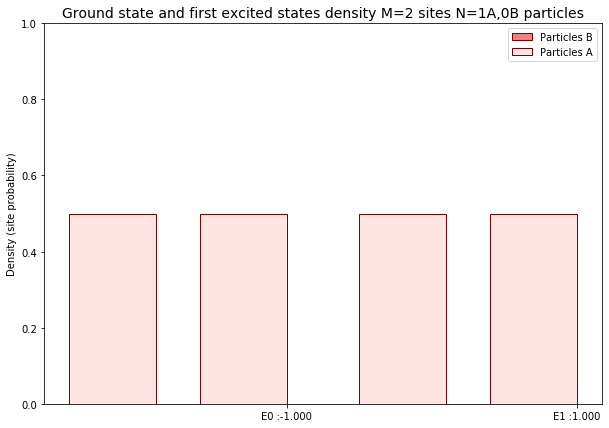

In [24]:
# width of the bars
barWidth = 0.3
 
# Choose the height of the blue bars
bars1 = densities_A[0]
bars2 = densities_B[0]

bars3 = densities_A[1]
bars4 = densities_B[1]

#bars5 = densities_A[2]
#bars6 = densities_B[2]


 
ticks =  (np.arange(len(bars1)))
# The x position of bars
r1 = ticks
r2 = [x + 1.5*barWidth for x in r1]
r3 = [x + 1.5*barWidth for x in r1]
r4 = [x + 1.5*barWidth for x in r1]
#r5 = [x + 6*barWidth for x in r1]
#r6 = [x + 7*barWidth for x in r1]


#title
plt.figure(figsize=(10,7))
plt.title('Ground state and first excited states density M={} sites N={}A,0B particles'.format(m,n), fontsize='14',y=1,x=0.5)
 
# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'mistyrose', edgecolor = 'maroon', capsize=7)
plt.bar(r2, bars2, width = barWidth, color = 'lightcoral', edgecolor = 'maroon', capsize=7)
plt.bar(r3, bars3, width = barWidth, color = 'mistyrose', edgecolor = 'maroon', capsize=7)
plt.bar(r4, bars4, width = barWidth, color = 'lightcoral', edgecolor = 'maroon', capsize=7)
#plt.bar(r5, bars5, width = barWidth, color = 'mistyrose', edgecolor = 'maroon', capsize=7)
#plt.bar(r6, bars6, width = barWidth, color = 'lightcoral', edgecolor = 'maroon', capsize=7)


dark_patch = mpatches.Patch(facecolor='lightcoral',edgecolor = 'maroon',label='Particles B')
light_patch = mpatches.Patch(facecolor='mistyrose',edgecolor = 'maroon', label='Particles A')
plt.legend(handles=[dark_patch,light_patch])

 
# general layout
#plt.xticks([r + 5*barWidth for r in ticks], ['E0 :{:.3f}'.format(autov[0]), 'E1 :{:.3f}'.format(autov[1]), 'E2 :{:.3f}'.format(autov[2])])
plt.xticks([r + 2*barWidth for r in ticks], ['E0 :{:.3f}'.format(autov[0]), 'E1 :{:.3f}'.format(autov[1])])
plt.ylabel(r'Density (site probability)')
plt.ylim(0,1)
 
p=plt.savefig('Groundstate_density_4S_na{}_nb0_r{}.jpg'.format(n,rd), format='jpg', dpi=300)